# Runs test 

In [31]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os, sys                                         
from os.path import dirname as parent_folde
import pandas as pd

In [32]:
sys.path.append('../AppStat/AppStat2021/External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax

sys.path.append('../AppStat/AppStat2021/Emilie_External_Functions')
from EmilieExternalFunctions import zerobin_hist, chi2_test, get_chi2_values

sys.path.append('BachelorExternalFunctions')
from Bachelor_ExternalFunctions import peak_plotter, peak_finder, compare_peaks
from Bachelor_ExternalFunctions import amp_plotter, amplitudes, get_min_idx
from Bachelor_ExternalFunctions import analyze_slips

In [421]:
# Set som plotting standards:

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)


save_plots = False

In [34]:
r = np.random # Random generator
r.seed(42)    # Set a random seed (but a fixed one)

In [77]:
resi_m = pd.read_csv(r'Data/resi_m_n4.csv', header=None, index_col=None).to_numpy()
resi_p = pd.read_csv(r'Data/resi_p_n4.csv', header=None, index_col=None).to_numpy()

In [78]:
# Shifting all mdm2 traces three places: 

roll_resi_m = np.zeros(shape=(402, 238))

for i in range(len(resi_m)): 
    roll_resi_m[i] = np.roll(resi_m[i], -3)

In [72]:
# Getting peaks for finding the peak areas: 
avefluct_m = 9.34
time = np.linspace(0, 287/2, 287)
t = time[49:]

In [73]:
def gradient_skips(data_p, data_m, peaks_p, local_min_p, ax=None): 
    
    local_min_p_idx = get_min_idx(data_p, local_min_p)  # Getting indices for local minima
    
    
    gradient_m = np.gradient(data_m)                    # Calculating the gradient for all mdm2 data
    norm_gradient_m = gradient_m / max(np.abs(gradient_m))      # Normalizing the values 
    
    
    # Getting all the peak areas: 
    
    peak_times = [t[:local_min_p_idx[0]+1]]              
    peak_areas_p = [data_p[:local_min_p_idx[0]+1]]
    peak_areas_m = [data_m[:local_min_p_idx[0]+1]]
    peak_areas_grad =[gradient_m[:local_min_p_idx[0]+1]]
    peak_areas_normgrad =[norm_gradient_m[:local_min_p_idx[0]+1]]
    
    for i in range(1, len(local_min_p_idx)):
        peak_times.append(t[local_min_p_idx[i-1]:local_min_p_idx[i]+1])
        peak_areas_p.append(data_p[local_min_p_idx[i-1]:local_min_p_idx[i]+1])
        peak_areas_m.append(data_m[local_min_p_idx[i-1]:local_min_p_idx[i]+1])
        peak_areas_grad.append(gradient_m[local_min_p_idx[i-1]:local_min_p_idx[i]+1])
        peak_areas_normgrad.append(norm_gradient_m[local_min_p_idx[i-1]:local_min_p_idx[i]+1])
        
    peak_times.append(t[local_min_p_idx[-1]:])
    peak_areas_p.append(data_p[local_min_p_idx[-1]:])
    peak_areas_m.append(data_m[local_min_p_idx[-1]:])
    peak_areas_grad.append(gradient_m[local_min_p_idx[-1]:])
    peak_areas_normgrad.append(norm_gradient_m[local_min_p_idx[-1]:])

    
    skips_idx = []
    
    for i in range(0, len(peak_areas_grad)): 
        if all(peak_areas_grad[i][j] <= 0 for j in range(0, len(peak_areas_grad[i])-1)):
            skips_idx.append(i)
            
    
    if ax: 
        ax.plot(t, data_p, color='green', label='p53')
        ax.plot(t, data_m, color='red', label='mdm2')
        ax.set(ylabel='Concentration', 
               xlim=(t[0]-1, t[-1]+1))
        ax.legend()
        for i in local_min_p_idx: 
            ax.vlines(t[i], min([min(data_p), min(data_m)]), 
                      max([max(data_p), max(data_m)]), linestyle='dashed', color='grey')
            
        for i in skips_idx:
            ax.plot(t[peaks_p[i]], data_p[peaks_p[i]], 'x', ms=8, mew=2, color='purple')
    
    return peak_times, peak_areas_p, peak_areas_m, peak_areas_normgrad, norm_gradient_m, skips_idx, peak_areas_grad

In [79]:
# Finding the peaks and local minima in all p53 traces:  
# These arrays are used to check for a negative/zero gradient in all of the p53 peak areas

all_peaks_p = []          # Index for peaks. Len 402
all_local_min_p = []      # Value of min before the peak. 

all_peaks_m = [] 
all_local_min_m = []

all_peak_times = []       # Areas around peaks 
all_peak_areas_p = []
all_peak_areas_m = [] 
all_peak_areas_grad = []
all_peak_areas_normgrad = []  # Gradient in each p53 peak area

all_gradients = []        # All gradients along a trace for mdm2 
all_skips = []            # Index of area, where the gradients are negative/zero

mdm2_slips = []          # p53 indices of skips from comparison of peaks 


for i in range(len(resi_p)): 
    
    peaks_p, min_p = peak_finder(resi_p[i], N_peaks='high', threshold=avefluct_m)
    peaks_m, min_m = peak_finder(roll_resi_m[i], N_peaks='low', threshold=avefluct_m)
    
    all_peaks_p.append(peaks_p)   
    all_local_min_p.append(min_p)
    all_peaks_m.append(peaks_m)   
    all_local_min_m.append(min_m)
    
    (peak_times, peak_areas_p, peak_areas_m, 
     peak_areas_normgrad, normgradient, skips, peak_areas_grad) = gradient_skips(resi_p[i], roll_resi_m[i], 
                                                               peaks_p, min_p, ax=None)
    all_peak_times.append(peak_times)
    all_peak_areas_p.append(peak_areas_p)
    all_peak_areas_m.append(peak_areas_m)
    all_peak_areas_grad.append(peak_areas_grad)
    all_peak_areas_normgrad.append(peak_areas_normgrad)
    all_gradients.append(normgradient)
    all_skips.append(skips) 
    
    slips = compare_peaks(peaks_p, peaks_m, min_p)[1]
    mdm2_slips.append(slips)

In [75]:
# Runs test on gradients: 

def getRuns(l):
    
    N1 = 0 
    N0 = 0 
    
    for i in range(len(l)): 
        if l[i] == 1: 
            N1 +=1
        else: 
            N0 +=1
        
    diff = np.diff(l)
    
    Runs  = len(diff[(diff == 1)]) + len(diff[(diff == -1)]) + 1
    
    return Runs, N1, N0 



def getRunsresults(Runs, N1, N0):
    N = N1 + N0
    mean = (2 * N0 * N1 / N) + 1
    sigma = np.sqrt((mean - 1) * (mean - 2) / (N - 1))
    return mean, sigma 

In [104]:
# Runs test for all gradient traces:

Runs_fulltrace = []
mu_Runs_fulltrace = [] 
sigma_Runs_fulltrace = []


for i in all_gradients:
    bool_array = np.zeros_like(i)
    for j in range(len(i)): 
        if i[j] > 0:
            bool_array[j] = 1
        else: 
            bool_array[j] = 0 
    
    runs, N_plus, N_minus = getRuns(bool_array)
    mean, sigma = getRunsresults(runs, N_plus, N_minus)
    
    Runs_fulltrace.append(runs)
    mu_Runs_fulltrace.append(mean)
    sigma_Runs_fulltrace.append(sigma)

In [106]:
# Result of runs test for full traces: 

Runs_fulltrace_mean = np.mean(Runs_fulltrace)
Runs_fulltrace_std = np.std(Runs_fulltrace)

print(f'The average number of runs is: {Runs_fulltrace_mean:2.1f} +/- {Runs_fulltrace_std:2.1f}')
print(f'The theoretical average number of runs is: {np.mean(mu_Runs_fulltrace):2.1f} +/- {np.mean(sigma_Runs_fulltrace):2.1f}')
print('Large deviation between the two means.')

z_score_fulltrace = [np.abs(Runs_fulltrace[i] - mu_Runs_fulltrace[i]) / sigma_Runs_fulltrace[i] for i in range(len(Runs))]
p_score_fulltrace = 2 * stats.norm.sf(z_score_fulltrace)

print(f'Average probability that the gradients are random: {np.mean(p_score_fulltrace):2.2}')

The average number of runs is: 60.3 +/- 7.1
The theoretical average number of runs is: 117.7 +/- 7.6
Large deviation between the two means.
Average probability that the gradients are random: 1e-06


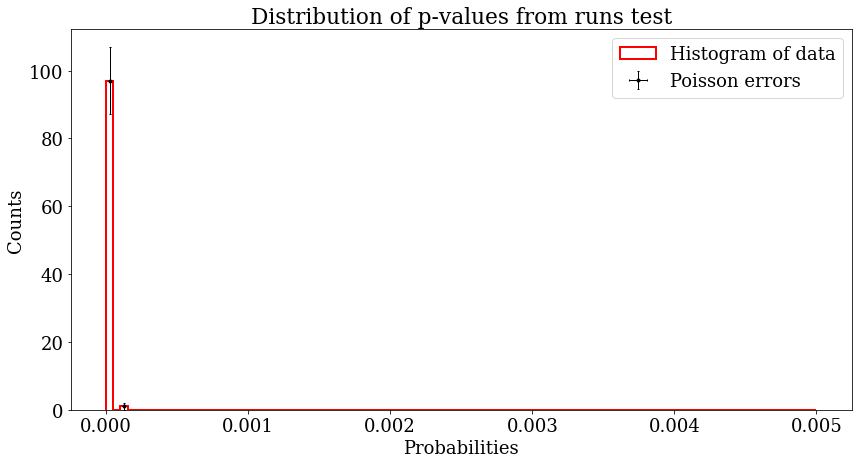

In [156]:
# Plotting the probabilities: 

fig, ax = plt.subplots(figsize=(14,7))

x, y, sy = zerobin_hist(p_score_fulltrace, bins=100, xmin=0, xmax=0.005, ax=ax)
ax.set(xlabel='Probabilities', 
       ylabel='Counts',
       title='Distribution of p-values from runs test')

if save_plots: 
    plt.savefig(r'Graphs/DistPValsRun.png');

In [415]:
# Runs test on the areas with zero/negative gradient: 
# Remember to make the Runs test on the mdm2 values, not gradients!! 
# Maybe it doesn't make sense to make runs test on these areas as the gradients are all negative/zero. 
# Instead of making bool array with positive/negative values

Runs_neg = []
mu_Runs_neg = [] 
sigma_Runs_neg = []

gradient_Runs_neg = [] 
Runs_area_size_neg = []

z_test_pscore_neg = []

for i in range(len(all_skips)): 
    for j in range(len(all_skips[i])): 
        
        if 0 <= np.max(all_peak_areas_grad[i][j]):   # If the maximum gradient in the area is negative/zero 
            
            if len(all_peak_areas_grad[i][j]) <= 3:                # Seperating the very small areas 
                count_too_small += 1 
                
            else: 
                m_area = all_peak_areas_m[i][j]
                
                z_test_pscore_neg.append(2 * stats.norm.sf((np.max(m_area) - np.mean(m_area)) / np.std(m_area, ddof=1)))
                
                gradient_Runs_neg.append(np.max(m_area))
                Runs_area_size_neg.append(len(m_area))
                bool_array = np.zeros_like(m_area)   # Creating a booleran array for Runs test 
                
                for k in range(len(m_area)): 
                        if m_area[k] > 0:
                            bool_array[k] = 1
                        else: 
                            bool_array[k] = 0 

                runs, N_plus, N_minus = getRuns(bool_array)
                mean, sigma = getRunsresults(runs, N_plus, N_minus)

                Runs_neg.append(runs)
                mu_Runs_neg.append(mean)
                sigma_Runs_neg.append(sigma)

In [420]:
# Getting the results of the Runs test on individual areas with zero/negative gradient: 

Runs_mean_neg = np.mean(Runs_neg)
Runs_std_neg = np.std(Runs_neg)

p_score_neg = []

for i in range(len(Runs_neg)):
    mask = np.array(sigma_Runs_neg[i]) > 0
    z = [np.abs(np.array(Runs_neg[i])[mask][j] - np.array(mu_Runs_neg[i])[mask][j]) / np.array(sigma_Runs_neg[i])[mask][j] for j in range(len(np.array(Runs_neg[i])[mask]))]
    p = 2 * stats.norm.sf(z)
        
    p_score_neg.append(np.mean(p))

print(f'The average number of runs is: {Runs_mean_neg:2.1f} +/- {Runs_std_neg:2.1f}')
print(f'The theoretical average number of runs is: {np.mean(mu_Runs_neg):2.1f} +/- {np.mean(sigma_Runs_neg):2.1f}')


print(f'Average z-score in units of sigma: {np.mean(z_score_neg):2.2}')
print(f'Average probability that the gradients are random: {np.mean(p_score_neg):2.2}')




The average number of runs is: 2.4 +/- 0.8
The theoretical average number of runs is: 3.9 +/- 0.9
Average z-score in units of sigma: nan
Average probability that the gradients are random: nan


In [110]:
# Counting the number of areas with zero/negative gradient and areas with small positive gradient: 

gradient_cut = 0.1 + 0.238    # Value + error on a from fit in Mdm2Gradient file 
count_areas_neggrad = 0 
count_areas = 0 

for i in all_peak_areas_grad: 
    for j in range(len(i)): 
        if 0 >=  np.max(i[j]): 
            count_areas_neggrad += 1
        if 0 < np.max(i[j]) < gradient_cut: 
            count_areas += 1
            
print(f'The number of areas with only zero/negative gradients: {count_areas_neggrad}')
print(f'The number of areas with slightly positive gradients: {count_areas}')

The number of areas with only zero/negative gradients: 426
The number of areas with slightly positive gradients: 106


In [322]:
gradient_cut = 0.1 + 0.238   # Value + error on a from fit in Mdm2Gradient file 

count_too_small = 0 

Runs = []
mu_Runs = [] 
sigma_Runs = []

gradient_Runs = [] 
Runs_area_size = []

z_test_pscore = []

for i in all_peak_areas_grad: 
    for j in range(len(i)): 
        
        if 0 < np.max(i[j]) < gradient_cut:   # If the maximum gradient in the area is in the range 
            
            if len(i[j]) <= 3:                # Seperating the very small areas 
                count_too_small += 1 
                
            else: 
                
                z_test_pscore.append(2 * stats.norm.sf((np.max(i[j]) - np.mean(i[j])) / np.std(i[j], ddof=1)))
                
                gradient_Runs.append(np.max(i[j]))
                Runs_area_size.append(len(i[j]))
                bool_array = np.zeros_like(i[j])   # Creating a booleran array for Runs test 
                
                for k in range(len(i[j])): 
                        if i[j][k] > 0:
                            bool_array[k] = 1
                        else: 
                            bool_array[k] = 0 

                runs, N_plus, N_minus = getRuns(bool_array)
                mean, sigma = getRunsresults(runs, N_plus, N_minus)

                Runs.append(runs)
                mu_Runs.append(mean)
                sigma_Runs.append(sigma)

In [200]:
# Getting the results of the Runs test on individual areas: 

Runs_mean = np.mean(Runs)
Runs_std = np.std(Runs)

print(f'The average number of runs is: {Runs_mean:2.1f} +/- {Runs_std:2.1f}')
print(f'The theoretical average number of runs is: {np.mean(mu_Runs):2.1f} +/- {np.mean(sigma_Runs):2.1f}')
print('Small deviation between the two means.')

z_score = [np.abs(Runs[i] - mu_Runs[i]) / sigma_Runs[i] for i in range(len(Runs))]
p_score = 2 * stats.norm.sf(z_score)

print(f'Average z-score in units of sigma: {np.mean(z_score):2.2}')
print(f'Average probability that the gradients are random: {np.mean(p_score):2.2}')

The average number of runs is: 2.8 +/- 1.0
The theoretical average number of runs is: 3.0 +/- 0.5
Small deviation between the two means.
Average z-score in units of sigma: 1.1
Average probability that the gradients are random: 0.33


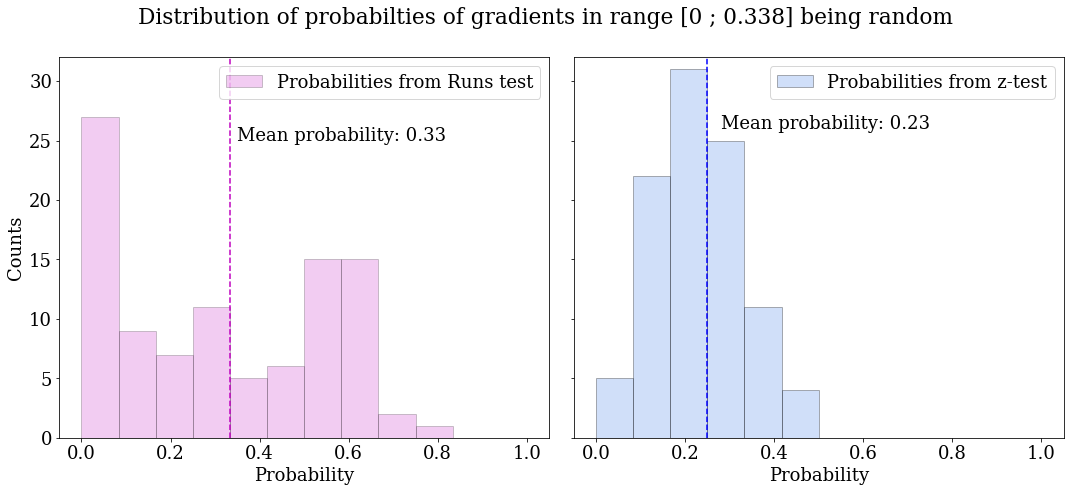

In [302]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,7), sharey=True)
suptitle = fig.suptitle(f'Distribution of probabilties of gradients in range [0 ; {gradient_cut:.3f}] being random')

counts_r, binedges_r, _ = ax[0].hist(p_score, bins=12, range=(0,1), 
                                     color='m', alpha=0.2, edgecolor='k', label='Probabilities from Runs test')

ax[0].set(xlabel='Probability', 
       ylabel='Counts', 
       ylim=(0, 32))

ax[0].vlines(binedges_r[np.where(np.isclose(np.mean(p_score), binedges_r, rtol=0.1))], 0, 32, 
             color='m', linestyle='dashed')

ax[0].text(0.35, 25, f'Mean probability: {np.mean(p_score):.2f}')

ax[0].legend()

counts_z, binedges_z, _ = ax[1].hist(z_test_pscore, bins=12, range=(0,1), 
                                     color='cornflowerblue', alpha=0.3, edgecolor='k', label='Probabilities from z-test')

ax[1].set(xlabel='Probability')

ax[1].vlines(binedges[np.where(np.isclose(np.mean(z_test_pscore), binedges_z, rtol=0.1))], 0, 32, 
             color='b', linestyle='dashed')

ax[1].text(0.28, 26, f'Mean probability: {np.mean(z_test_pscore):.2f}')

ax[1].legend()

fig.subplots_adjust(wspace=0.05)


if save_plots: 
    plt.savefig(r'Graphs/DistRandomGrads.png', bbox_inches='tight', bbox_extra_artists=[suptitle]);

In [401]:
# Doing the Runs test on gradient in peak areas, where the maximum gradient range is being increased: 

Runs_nsigma = []
mu_Runs_nsigma = [] 
sigma_Runs_nsigma = []

gradient_Runs_nsigma = [] 
Runs_area_size_nsigma = []

z_test_pscore_nsigma = []

gradient_ranges = np.arange(-16, 30, 2)

for n in gradient_ranges:   
    
    r = [] 
    m = []
    s = []
    z = []
    
    for i in all_peak_areas_grad: 
        for j in range(len(i)): 
        
            if n < np.max(i[j]) < n+3:   # If the maximum gradient in the area is in the range: 

                if len(i[j]) >= 3:                           # Seperating the very small areas 

                    gradient_Runs_nsigma.append(np.max(i[j]))
                    Runs_area_size_nsigma.append(len(i[j]))
                    
                    bool_array = np.zeros_like(i[j])   # Creating a booleran array for Runs test 

                    for l in range(len(i[j])): 
                            if i[j][l] > 0:
                                bool_array[l] = 1
                            else: 
                                bool_array[l] = 0 

                    runs, N_plus, N_minus = getRuns(bool_array)
                    mean, sigma = getRunsresults(runs, N_plus, N_minus)
                    
                    r.append(runs)
                    m.append(mean)
                    s.append(sigma)   
                    z.append(2 * stats.norm.sf((np.max(i[j]) - np.mean(i[j])) / np.std(i[j], ddof=1)))
                    

    Runs_nsigma.append(r)
    mu_Runs_nsigma.append(m)
    sigma_Runs_nsigma.append(s)
    z_test_pscore_nsigma.append(z)

In [411]:
# Calculating the mean probability of gradients being random 

p_score_nsigma = [] 
z_test_pscore_nsigma_mean = []

for i in range(len(Runs_nsigma)):
    z_test_pscore_nsigma_mean.append(np.mean(z_test_pscore_nsigma[i]))
    mask = np.array(sigma_Runs_nsigma[i]) > 0
    z = [np.abs(np.array(Runs_nsigma[i])[mask][j] - np.array(mu_Runs_nsigma[i])[mask][j]) / np.array(sigma_Runs_nsigma[i])[mask][j] for j in range(len(np.array(Runs_nsigma[i])[mask]))]
    p = 2 * stats.norm.sf(z)
        
    p_score_nsigma.append(np.mean(p))

/Users/emiliejessen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/emiliejessen/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


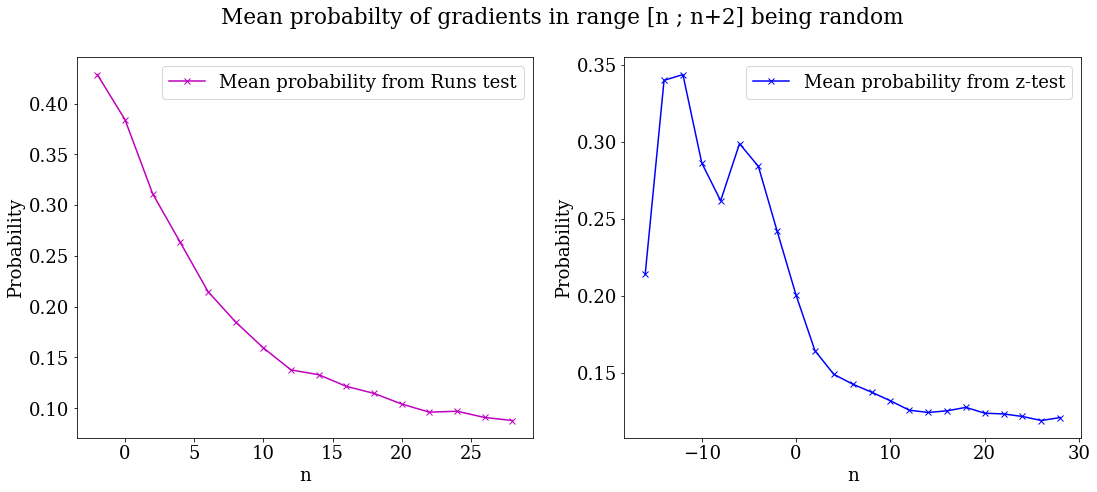

In [406]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
suptitle = fig.suptitle(f'Mean probabilty of gradients in range [n ; n+2] being random')


ax[0].plot(gradient_ranges, p_score_nsigma, color='m', marker='x', label='Mean probability from Runs test')

ax[0].set(xlabel='n', 
       ylabel='Probability')


ax[0].legend()

ax[1].plot(gradient_ranges, z_test_pscore_nsigma_mean, color='b', marker='x', label='Mean probability from z-test')

ax[1].set(xlabel='n', 
          ylabel='Probability')


ax[1].legend()

fig.subplots_adjust(wspace=0.2)


if save_plots: 
    plt.savefig(r'Graphs/PropRandomGradsXn.png', bbox_inches='tight', bbox_extra_artists=[suptitle]);